## Importing Libraries

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

import torchvision.transforms as transforms
import torchvision.models as models

from PIL import Image
import requests
from io import BytesIO
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from transformers import ViTFeatureExtractor, ViTForImageClassification
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder
from sklearn.metrics import accuracy_score
import torchvision.transforms.functional as F


import numpy as np
import pandas as pd
import requests
import torch
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import pickle

In [3]:
# Set device to GPU if available, otherwise fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
print("Using device:", device)

Using device: cpu


## Reading Dataset and Preprocessing

In [10]:
df = pd.read_csv("/content/sampled_data.csv")

In [11]:
def find_duplicates(df, column_name):

    duplicate_entries = df[df.duplicated(subset=column_name, keep=False)]

    grouped_duplicates = duplicate_entries.groupby(column_name).apply(lambda x: x.index.tolist())

    duplicates_dict = grouped_duplicates.to_dict()

    # Display the duplicates
    if duplicates_dict:
        print(f" Found duplicates in column '{column_name}':")
        for value, indices in duplicates_dict.items():
            print(f" - {column_name.capitalize()} '{value}' has duplicates at indices: {indices}")
    else:
        print(f"No duplicates found in column '{column_name}'.")

    return duplicates_dict


In [12]:
# # Assuming your DataFrame is named df
# duplicates = find_duplicates(df, 'barcode')


In [13]:
# Remove columns where all values are null
# axis=1 specifies columns, and how='all' drops only if all values in the column are NaN
df = df.dropna(axis=1, how='all')

# Remove duplicate rows from the DataFrame
df = df.drop_duplicates()

# Drop the 'gender' column from the DataFrame
df = df.drop(columns=['gender'])

# Keep rows where all specified columns are non-null
required_columns = ['category', 'style', 'colors', 'pattern', 'occasion']
df = df.dropna(subset=required_columns)


# Replace all NaN (missing) values in the DataFrame with the string "Not Known"
df = df.fillna("Not Known")



# Remove leading/trailing whitespaces from each color value
# Remove spaces around semicolons completely
df['colors'] = df['colors'].str.strip()
df['colors'] = df['colors'].apply(lambda x: ';'.join(color.strip() for color in x.split(';')))


# Remove leading/trailing whitespaces from each pattern value
# Remove spaces around semicolons completely
df['pattern'] = df['pattern'].str.strip()
df['pattern'] = df['pattern'].apply(lambda x: ';'.join(color.strip() for color in x.split(';')))


# Remove leading/trailing whitespaces from each occasion value
# Remove spaces around semicolons completely
df['occasion'] = df['occasion'].str.strip()
df['occasion'] = df['occasion'].apply(lambda x: ';'.join(color.strip() for color in x.split(';')))

# Remove leading/trailing whitespaces from each more_attributes value
# Remove spaces around semicolons completely
df['more_attributes'] = df['more_attributes'].str.strip()
df['more_attributes'] = df['more_attributes'].apply(lambda x: ';'.join(color.strip() for color in x.split(';')))


In [15]:
# df.info()
# # After preprocessing we have 392 rows.

## Dataset exploration

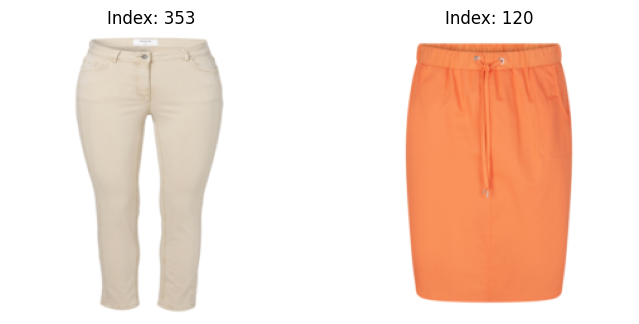


Image 353 Attributes:
image_url_1: https://fotos.skm.be/article/508890/508890_01_64785c08be819a0010a659e2.jpg
category: jeans
style: casual
colors: ecru
pattern: plain
occasion: casual
more_attributes: Not Known
material: Not Known
tops_fit: Not Known
sleeve_type: Not Known
tops_length: Not Known
overclothes_closure: Not Known
blazer_neckline_type: Not Known
underarm_sleeve_length: Not Known
neckline_type: Not Known
sleeve_length: Not Known
heels_height: Not Known
overclothes_neckline_type: Not Known
overclothes_type: Not Known
waist_type: mid-waist
bottoms_length: 3-4-long
skirt_type: Not Known
skirt_length: Not Known
bottoms_fit: slim-bottoms
jumpsuit_length: Not Known
overclothes-sleeveless_type: Not Known
poncho_type: Not Known
slippers-shoe_type: Not Known
sportswear_type: Not Known
sweatshirt_type: Not Known
tank_type: Not Known
bottoms_type: Not Known
barcode: 50889001080101
brand: Frapp

Columns with null values:
None

Image 120 Attributes:
image_url_1: https://fotos.skm.be/ar

In [16]:
# Define transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

def process_and_display_images(df, indices):
    def load_image(url):
        try:
            response = requests.get(url, timeout=5)
            image = Image.open(BytesIO(response.content)).convert("RGB")
            return transform(image)
        except:
            return torch.zeros((3, 224, 224))

    # Ensure indices are valid
    valid_indices = [idx for idx in indices if idx < len(df)]

    # Load selected images
    selected_images = [load_image(df.iloc[idx]['image_url_1']) for idx in valid_indices]

    # Display the selected images
    plt.figure(figsize=(8, 4))
    for i, (img, idx) in enumerate(zip(selected_images, valid_indices)):
        plt.subplot(1, len(valid_indices), i + 1)
        plt.imshow(img.permute(1, 2, 0))  # Rearrange dimensions for visualization
        plt.axis("off")
        plt.title(f"Index: {idx}")
    plt.show()

    # Print non-null and null attributes for selected images
    for idx in valid_indices:
        print(f"\nImage {idx} Attributes:")
        non_null_values = df.iloc[idx].dropna()
        for col, value in non_null_values.items():
            print(f"{col}: {value}")

        null_columns = df.columns[df.iloc[idx].isnull()]
        print("\nColumns with null values:")
        print(", ".join(null_columns) if len(null_columns) > 0 else "None")


process_and_display_images(df, [353, 120])

In [17]:
# Goal: Printing the number of unique values and all unique values for each column in the dataset.
def count_unique_values(df):

    for column in df.columns:
        unique_values = df[column].unique()
        num_unique_values = len(unique_values)

        print("\n" + "=" * 50)
        print(f"Analysis of '{column}' Column")
        print(f"Total Unique Values: {num_unique_values}\n")
        print(" Unique Values:")
        print("-" * 50)

        for value in unique_values:
            print(f" {value}")

        print("=" * 50)

In [18]:
count_unique_values(df)


Analysis of 'image_url_1' Column
Total Unique Values: 392

 Unique Values:
--------------------------------------------------
 https://fotos.skm.be/article/489205/489205_02_642adb1670216c001194fc17.jpg
 https://fotos.skm.be/article/507927/507927_01_6488eab8d7dc2e001087c0fd.jpg
 https://fotos.skm.be/article/505938/505938_01_64ff0a6c07ed590011484286.jpg
 https://fotos.skm.be/article/479883/479883_01_617284f48b44f30011ac308f.jpg
 https://fotos.skm.be/article/483726/483726_01_6706-60-1.jpg
 https://fotos.skm.be/article/487940/487940_01_620f7e302ec3e10012a2addf.jpg
 https://fotos.skm.be/article/499751/499751_01_62695f6f6319310013a3eb14.jpg
 https://fotos.skm.be/article/482163/482163_01_61e76a1af1b23b0011f79dd8.jpg
 https://fotos.skm.be/article/488976/488976_01_223966-110-1-WEB.jpg
 https://fotos.skm.be/article/477567/477567_01_617741aa93c6900011d300ed.jpg
 https://fotos.skm.be/article/499150/499150_02_30307546_301963_500.jpg
 https://fotos.skm.be/article/500045/500045_01_6386ac32741f4a0011

# Classification Model

## Data PreProcessing

In [19]:
# Identify Multi-Label Columns
multi_label_columns = ["colors", "pattern", "occasion", "more_attributes"]
one_hot_columns = [
 'category',
 'style',
 'material',
 'tops_fit',
 'sleeve_type',
 'tops_length',
 'overclothes_closure',
 'blazer_neckline_type',
 'underarm_sleeve_length',
 'neckline_type',
 'sleeve_length',
 'heels_height',
 'overclothes_neckline_type',
 'overclothes_type',
 'waist_type',
 'bottoms_length',
 'skirt_type',
 'skirt_length',
 'bottoms_fit',
 'jumpsuit_length',
 'overclothes-sleeveless_type',
 'poncho_type',
 'slippers-shoe_type',
 'sportswear_type',
 'sweatshirt_type',
 'tank_type',
 'bottoms_type']




# Multi-Label Encoding
for col in multi_label_columns:
    # print(df[col].head(10))
    df[col] = df[col].fillna('').astype(str)  # Convert NaNs to empty strings, then ensure string format
    df[col] = df[col].apply(lambda x: x.split(';') if isinstance(x, str) and x.strip() else [])  # Split string into a list
    # print("\nAfter Transformation:")
    # print(df[col].head(10))




In [20]:
mlb_dfs = []  # Store transformed DataFrames for each column
for col in multi_label_columns:
    mlb = MultiLabelBinarizer()
    encoded = mlb.fit_transform(df[col])  # Each column is a list of strings
    encoded_df = pd.DataFrame(encoded, columns=[f"{col}_{cls}" for cls in mlb.classes_])
    mlb_dfs.append(encoded_df)

# Concatenate Transformed DataFrames
encoded_multi_labels_df = pd.concat(mlb_dfs, axis=1)
# encoded_multi_labels_df

In [21]:
# Drop original multi-label columns and merge back
df = df.drop(columns=multi_label_columns).reset_index(drop=True)
df = pd.concat([df, encoded_multi_labels_df], axis=1)

# Verify the transformed DataFrame
# print(encoded_multi_labels_df.head())

In [22]:
# One-Hot Encoding
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
one_hot_encoded = encoder.fit_transform(df[one_hot_columns])
one_hot_encoded_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(one_hot_columns))
df = df.drop(columns=one_hot_columns).reset_index(drop=True)
df = pd.concat([df, one_hot_encoded_df], axis=1)

# One-Hot Encode the brand column
brand_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
brand_encoded = brand_encoder.fit_transform(df[['brand']])
brand_encoded_df = pd.DataFrame(brand_encoded, columns=brand_encoder.get_feature_names_out(['brand']))

# Drop original brand column and merge the encoded one
df = df.drop(columns=['brand']).reset_index(drop=True)
df = pd.concat([df, brand_encoded_df], axis=1)
df = df.reset_index(drop=True)

In [23]:
IMG_SIZE = (224, 224)
transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [24]:

def load_image(url):

      response = requests.get(url, timeout=5)
      image = Image.open(BytesIO(response.content)).convert("RGB")
      return transform(image)


# Data augmentation functions
import torchvision.transforms.functional as F

# Data augmentation functions
def augment_image(image):
    augmented_images = []

    # Flip horizontally
    flipped = F.hflip(image)
    augmented_images.append(flipped)

    # Rotate by a random angle between -30 and 30 degrees
    angle = random.uniform(-30, 30)
    rotated = F.rotate(image, angle)
    augmented_images.append(rotated)

    return augmented_images


In [ ]:

# Custom Dataset Class
class FashionDataset(Dataset):
    def __init__(self, dataframe):
        self.image_urls = dataframe["image_url_1"].values
        self.brand_features = dataframe.filter(like='brand_').values  # Brand features
        self.labels = dataframe.drop(columns=["image_url_1", "barcode"] + list(brand_encoded_df.columns)).values
        self.barcodes = dataframe["barcode"].values
        self.column_names = dataframe.columns
        self.data = []  # Store images and labels

        for idx in tqdm(range(len(self.image_urls)), desc="Processing Images"):
            image = load_image(self.image_urls[idx])
            label = torch.tensor(self.labels[idx], dtype=torch.float32)

            # Add original image
            self.data.append((image, label))

            # Apply augmentations
            augmented_images = augment_image(image)
            for aug_img in augmented_images:
                self.data.append((aug_img, label))  # Augmented images retain the same label

        # Shuffle dataset after gathering all data
        random.shuffle(self.data)


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if idx >= len(self.image_urls):
          idx = idx % len(self.image_urls)
        image = load_image(self.image_urls[idx])
        brand_feature = torch.tensor(self.brand_features[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        barcode = self.barcodes[idx]
        return image, brand_feature, label, barcode




# Model Definition
class FashionClassifier(nn.Module):
    def __init__(self, num_labels, brand_feature_size):
        super(FashionClassifier, self).__init__()
        self.cnn = models.efficientnet_b0(pretrained=True)
        self.cnn.classifier = nn.Identity()  # Remove the default classifier
        self.fc = nn.Sequential(
            nn.Linear(1280 + brand_feature_size, 512),  # Concatenate image and brand features
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_labels),
            nn.Sigmoid()  
        )

    def forward(self, image, brand_features):
        image_features = self.cnn(image)
        combined_features = torch.cat((image_features, brand_features), dim=1)
        output = self.fc(combined_features)
        return output

In [26]:
# Prepare DataLoader
dataset = FashionDataset(df)


Processing Images: 100%|██████████| 392/392 [08:02<00:00,  1.23s/it]


In [ ]:


# # Get the first row from the dataset
# first_row_dict = {}

# # Add image URL and barcode
# first_row_dict['image_url_1'] = dataset.image_urls[0]
# first_row_dict['barcode'] = dataset.barcodes[0]

# # Add brand features
# brand_feature_values = dataset.brand_features[0]
# brand_columns = [col for col in dataset.column_names if col.startswith('brand_')]
# first_row_dict.update(dict(zip(brand_columns, brand_feature_values)))

# # Add label values (colors, patterns, etc.)
# label_values = dataset.labels[0]
# label_columns = list(dataset.column_names.drop(["image_url_1", "barcode"] + list(brand_columns)))
# first_row_dict.update(dict(zip(label_columns, label_values)))

# # Convert to DataFrame for display
# first_row_df = pd.DataFrame([first_row_dict])

# # Set Pandas display options to show all columns
# pd.set_option('display.max_columns', None)  # Show all columns
# pd.set_option('display.max_rows', None)     # (Optional) Show all rows if needed
# pd.set_option('display.width', None)        # Prevent line wrapping
# pd.set_option('display.max_colwidth', None) # Show full content in each cell

# # Display the DataFrame
# display(first_row_df)


In [28]:
# def get_info_by_barcode(dataset, barcode_to_find):
#     # Check if the barcode exists
#     if barcode_to_find not in dataset.barcodes:
#         print(f"Barcode {barcode_to_find} not found in the dataset.")
#         return None

#     # Find the index of the barcode
#     idx = list(dataset.barcodes).index(barcode_to_find)

#     # Extract information
#     barcode_info = {}

#     # Add image URL and barcode
#     barcode_info['image_url_1'] = dataset.image_urls[idx]
#     barcode_info['barcode'] = dataset.barcodes[idx]

#     # Add brand features
#     brand_feature_values = dataset.brand_features[idx]
#     brand_columns = [col for col in dataset.column_names if col.startswith('brand_')]
#     barcode_info.update(dict(zip(brand_columns, brand_feature_values)))

#     # Add label values (colors, patterns, etc.)
#     label_values = dataset.labels[idx]
#     label_columns = list(dataset.column_names.drop(["image_url_1", "barcode"] + list(brand_columns)))
#     barcode_info.update(dict(zip(label_columns, label_values)))

#     # Convert to DataFrame for display
#     barcode_info_df = pd.DataFrame([barcode_info])

#     # Set Pandas display options to show all columns
#     pd.set_option('display.max_columns', None)
#     pd.set_option('display.max_rows', None)
#     pd.set_option('display.width', None)
#     pd.set_option('display.max_colwidth', None)

#     # Display the DataFrame
#     display(barcode_info_df)
#     return barcode_info_df


In [29]:
# # Example barcode to search for
# barcode_to_search = '49827602030101'

# # Get info for the specific barcode
# barcode_info_df = get_info_by_barcode(dataset, barcode_to_search)


In [30]:
print("Total number of columns:", len(dataset.column_names))


Total number of columns: 344


In [31]:
# Print each column name on a new line
for col in dataset.column_names:
    print(col)


image_url_1
barcode
colors_beige
colors_black
colors_blue
colors_bordeaux
colors_brown
colors_canyon-rose
colors_coral
colors_ecru
colors_emerald-green
colors_gold
colors_gray
colors_green
colors_khaki
colors_lavander
colors_magenta
colors_mint
colors_multicolor
colors_mustard
colors_navy
colors_neon
colors_orange
colors_pastel
colors_pink
colors_purple
colors_red
colors_silver
colors_turquoise
colors_white
colors_yellow
pattern_abstract
pattern_animal-print
pattern_animals
pattern_bird's-eye
pattern_bleached
pattern_brocade
pattern_brush-stroke
pattern_camo
pattern_checkerboard
pattern_chevron
pattern_damask
pattern_diagonal-stripes
pattern_dots
pattern_floral
pattern_fruits
pattern_geometric
pattern_gingham
pattern_glen-check
pattern_glitter
pattern_graph-check
pattern_harlequin
pattern_horizontal-stripes
pattern_houndstooth
pattern_leaf
pattern_marled
pattern_natural
pattern_net
pattern_ombre
pattern_paisley
pattern_plain
pattern_quilted
pattern_retro
pattern_shapes
pattern_stripes


In [32]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

In [33]:
# Training Setup

num_labels = df.shape[1] - len(brand_encoded_df.columns) - 2
brand_feature_size = len(brand_encoded_df.columns)

model = FashionClassifier(num_labels, brand_feature_size).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
epochs = 3
for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_labels = 0

    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{epochs}", ncols=100)

    for batch_idx, (images, brand_features, labels, _) in progress_bar:
        images, brand_features, labels = images.to(device), brand_features.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images, brand_features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Accumulate loss
        total_loss += loss.item()

        # Calculate accuracy for multi-label predictions
        predicted = (outputs > 0.5).float()
        correct = (predicted == labels).sum().item()
        total_correct += correct
        total_labels += labels.numel()

        # Update progress bar description dynamically
        accuracy = (total_correct / total_labels) * 100
        progress_bar.set_postfix({
            "Loss": f"{loss.item():.4f}",
            "Batch Acc": f"{accuracy:.2f}%"
        })

    # Epoch Summary
    avg_loss = total_loss / len(train_loader)
    epoch_accuracy = (total_correct / total_labels) * 100
    print(f"\n Epoch [{epoch + 1}/{epochs}] Summary:")
    print(f" - Average Loss: {avg_loss:.4f}")
    print(f" - Training Accuracy: {epoch_accuracy:.2f}%\n")

# Save the trained model
model_save_path = "fashion_model.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved successfully at {model_save_path}")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 79.9MB/s]
Epoch 1/3: 100%|█████████████████████| 59/59 [22:48<00:00, 23.20s/it, Loss=0.1552, Batch Acc=93.11%]



 Epoch [1/3] Summary:
 - Average Loss: 0.2119
 - Training Accuracy: 93.11%



Epoch 2/3: 100%|█████████████████████| 59/59 [22:47<00:00, 23.18s/it, Loss=0.1049, Batch Acc=95.67%]



 Epoch [2/3] Summary:
 - Average Loss: 0.1247
 - Training Accuracy: 95.67%



Epoch 3/3: 100%|█████████████████████| 59/59 [22:39<00:00, 23.04s/it, Loss=0.1069, Batch Acc=96.24%]


 Epoch [3/3] Summary:
 - Average Loss: 0.1036
 - Training Accuracy: 96.24%

Model saved successfully at fashion_model.pth


In [35]:
# Reconstruct label columns for use during inference
brand_columns = [col for col in df.columns if col.startswith('brand_')]
label_columns = list(df.drop(columns=["image_url_1", "barcode"] + brand_columns).columns)


In [36]:
# Inference and Save Metadata
model.eval()
predictions = []
total_correct = 0
total_labels = 0

with torch.no_grad():
    for images, brand_features, labels, barcodes in tqdm(test_loader, desc="Running Inference"):
        images, brand_features, labels = images.to(device), brand_features.to(device), labels.to(device)
        outputs = model(images, brand_features)
        outputs = (outputs > 0.5).int()

        # Accuracy Calculation
        correct = (outputs == labels).sum().item()
        total_correct += correct
        total_labels += labels.numel()

        # Convert predictions to DataFrame format
        outputs_np = outputs.cpu().numpy()
        brand_features_np = brand_features.cpu().numpy()

        for barcode, brand_feature, output in zip(barcodes, brand_features_np, outputs_np):
            # Extract decoded brand features
            brand_metadata = {col_name: int(value) for col_name, value in zip(brand_encoded_df.columns, brand_feature)}

            # Extract predicted metadata
            predicted_metadata = {col_name: int(value) for col_name, value in zip(label_columns, output.tolist())}

            # Append final metadata
            predictions.append({
                "barcode": barcode,
                **brand_metadata,
                **predicted_metadata
            })

# Calculate overall accuracy
accuracy = (total_correct / total_labels) * 100
print(f"✅ Inference Accuracy: {accuracy:.2f}%")

# Save predictions to CSV with barcode + brand metadata
predictions_df = pd.DataFrame(predictions)
predictions_csv_path = "predicted_metadata.csv"
predictions_df.to_csv(predictions_csv_path, index=False)
print(f"📁 Inferred metadata saved at {predictions_csv_path}")


Running Inference: 100%|██████████| 15/15 [05:00<00:00, 20.07s/it]

✅ Inference Accuracy: 96.82%
📁 Inferred metadata saved at predicted_metadata.csv


In [124]:
predictions_df = pd.read_csv("predicted_metadata.csv")

In [37]:
def decode_predictions(encoded_df):
    # Identify all column groups
    brand_columns = [col for col in encoded_df.columns if col.startswith('brand_')]
    color_columns = [col for col in encoded_df.columns if col.startswith('colors_')]
    pattern_columns = [col for col in encoded_df.columns if col.startswith('pattern_')]
    occasion_columns = [col for col in encoded_df.columns if col.startswith('occasion_')]
    more_attr_columns = [col for col in encoded_df.columns if col.startswith('more_attributes_')]

    # One-hot encoded single-value categorical columns
    single_label_columns = [
        'category', 'style', 'material', 'tops_fit', 'sleeve_type', 'tops_length',
        'overclothes_closure', 'blazer_neckline_type', 'underarm_sleeve_length', 'neckline_type',
        'sleeve_length', 'heels_height', 'overclothes_neckline_type', 'overclothes_type',
        'waist_type', 'bottoms_length', 'skirt_type', 'skirt_length', 'bottoms_fit',
        'jumpsuit_length', 'overclothes-sleeveless_type', 'poncho_type', 'slippers-shoe_type',
        'sportswear_type', 'sweatshirt_type', 'tank_type', 'bottoms_type'
    ]

    single_label_columns_encoded = [
        [col for col in encoded_df.columns if col.startswith(f"{feature}_")]
        for feature in single_label_columns
    ]

    # Initialize list for reconstructed data
    reconstructed_data = []

    # Loop over each row and decode
    for idx, row in encoded_df.iterrows():
        decoded_row = {
            'barcode': row['barcode']
        }

        # Decode brand
        active_brand = [col.replace('brand_', '') for col in brand_columns if row[col] == 1]
        decoded_row['brand'] = active_brand[0] if active_brand else 'Unknown'

        # Decode multi-label columns
        decoded_row['colors'] = ';'.join([col.replace('colors_', '') for col in color_columns if row[col] == 1])
        decoded_row['pattern'] = ';'.join([col.replace('pattern_', '') for col in pattern_columns if row[col] == 1])
        decoded_row['occasion'] = ';'.join([col.replace('occasion_', '') for col in occasion_columns if row[col] == 1])
        decoded_row['more_attributes'] = ';'.join([col.replace('more_attributes_', '') for col in more_attr_columns if row[col] == 1])

        # Decode single-label columns
        for feature, encoded_cols in zip(single_label_columns, single_label_columns_encoded):
            active_label = [col.replace(f'{feature}_', '') for col in encoded_cols if row[col] == 1]
            decoded_row[feature] = active_label[0] if active_label else 'Not Known'

        reconstructed_data.append(decoded_row)

    # Convert back to DataFrame
    reconstructed_df = pd.DataFrame(reconstructed_data)
    return reconstructed_df

# Assuming your predictions DataFrame is called `predicted_df`
reconstructed_df = decode_predictions(predictions_df)

# Display the reconstructed DataFrame
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
display(reconstructed_df)

# Save the reconstructed DataFrame
reconstructed_df.to_csv('reconstructed_original_format.csv', index=False)


,barcode,brand,colors,pattern,occasion,more_attributes,category,style,material,tops_fit,sleeve_type,tops_length,overclothes_closure,blazer_neckline_type,underarm_sleeve_length,neckline_type,sleeve_length,heels_height,overclothes_neckline_type,overclothes_type,waist_type,bottoms_length,skirt_type,skirt_length,bottoms_fit,jumpsuit_length,overclothes-sleeveless_type,poncho_type,slippers-shoe_type,sportswear_type,sweatshirt_type,tank_type,bottoms_type
0,tensor(50267401060101),Xandres Gold,,plain,casual,Not Known,trousers_and_chinos,casual,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known,high-waist,full-length,Not Known,Not Known,slim-bottoms,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known,classic-trousers
1,tensor(50391201080101),Verpass,,plain,casual;dating;nightout,Not Known,skirt,casual,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known,high-waist,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known
2,tensor(49911501410101),Yoek,multicolor,,casual;dating,Not Known,dress,feminine,Not Known,Not Known,straight-sleeve,Not Known,Not Known,Not Known,Not Known,v-neck,3-4-sleeve,Not Known,Not Known,Not Known,Not Known,Not Known,a-line,midi,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known
3,tensor(49032503020101),Lyle & Scott,black,plain,casual,Not Known,Not Known,casual,cotton,regular-fit-tops,straight-sleeve,Not Known,Not Known,Not Known,Not Known,Not Known,long-sleeve,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known
4,tensor(50558101050101),Mayerline,multicolor;white,floral;leaf,casual;dating,Not Known,Not Known,casual,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known,a-line,midi,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231,tensor(49349902030101),River Woods,green,,casual,Not Known,Not Known,casual,cotton,regular-fit-tops,straight-sleeve,short,Not Known,Not Known,Not Known,Not Known,long-sleeve,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known
232,tensor(49771601050101),GERRY WEBER EDITION,,,casual;semi-formal,Not Known,trousers_and_chinos,casual,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known,high-waist,full-length,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known,classic-trousers
233,tensor(49838001030101),Bloomings,blue;multicolor,leaf,casual,Not Known,t-shirt,casual,cotton,regular-fit-tops,Not Known,short,Not Known,Not Known,Not Known,round-neck,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known
234,tensor(49821001040101),Terre Bleue,multicolor,floral;leaf,casual;dating,Not Known,dress,feminine,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known,a-line,midi,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known,Not Known
